In [68]:
import sys
sys.path.append('../src')
import pandas as pd
import numpy
from pyomo.environ import ConstraintList
from energiapy.components.temporal_scale import TemporalScale
from energiapy.components.resource import Resource, VaryingResource
from energiapy.components.process import Process, VaryingProcess
from energiapy.components.material import Material
from energiapy.components.location import Location
from energiapy.components.network import Network
from energiapy.components.scenario import Scenario
from energiapy.components.transport import Transport
from energiapy.model.formulate import formulate, Constraints, Objective
from energiapy.utils.nsrdb_utils import fetch_nsrdb_data
from energiapy.plot import plot_results, plot_scenario
from energiapy.plot.plot_results import CostY, CostX
from energiapy.model.solve import solve
from itertools import product
from energiapy.components.result import Result
from itertools import product
from matplotlib import rc
import matplotlib.pyplot as plt
from energiapy.model.solve import solve
from energiapy.plot.plot_results import CostY, CostX
from energiapy.components.location import Location
from energiapy.plot import plot_results, plot_scenario
from energiapy.utils.nsrdb_utils import fetch_nsrdb_data
from energiapy.model.formulate import formulate, Constraints, Objective
from energiapy.model.bounds import CapacityBounds
from energiapy.utils.data_utils import get_data, make_henry_price_df, remove_outliers, load_results
from energiapy.conversion.photovoltaic import solar_power_output
from energiapy.conversion.windmill import wind_power_output
from energiapy.model.constraints.integer_cuts import constraint_block_integer_cut, constraint_block_integer_cut_min


def jimbos_shrimp(demand_case):
    horizon = 1
    scales = TemporalScale(discretization_list=[1, 24])
    bigM = 10**4
    smallM = 0.001
    #Electricity price is hourly
    elec_price_df = pd.read_csv('ERCOT_price.csv')
    elec_price_df = elec_price_df[elec_price_df['BusName'] == 'FORMOSA_G8']
    elec_price_df = elec_price_df[['LMP']].reset_index(drop = True)
    #The natural gas price is calculated as the average between the high and low cost, also the unit used is $/kg of natural gas
    NG_price_df = pd.read_csv('Naturalgas_price_hourly.csv')
    NG_price_df = pd.DataFrame(NG_price_df['USD/kg'])[::-1].reset_index()
    NG_price_df = NG_price_df[['USD/kg']]
    #NG_price_df
    #Gives relevancy to price values again
    elec_price = elec_price_df.max()[0]
    NG_price = NG_price_df.max()[0]
    Wind_df = pd.read_csv('Wind2424.csv')
    Wind_df = Wind_df[['ACTUAL_SYSTEM_WIDE']]
    Wind_df = Wind_df[:24]
    #Wind_df
    Solar_df = pd.read_csv('Solar2424.csv')
    Solar_df = Solar_df[['PVGRPP_SYSTEM_WIDE']]
    Solar_df = Solar_df[:24]
    Solar = Resource(name='Solar', cons_max=bigM, basis='MW', label='Solar Power', price= 52.69, gwp=0)

    Wind = Resource(name='Wind', cons_max=bigM, basis='MW', label='Wind Power', price= 60.11, gwp=0)

    Power = Resource(name='Power', basis='MW',
                    label='Power generated')

    GridPower = Resource(name='GridPower', basis='MW',
                        cons_max=bigM, label='Power bought', price = elec_price, varying = [VaryingResource.DETERMINISTIC_PRICE], gwp=420.62)

    #The following are components of natural gas

    CO2 = Resource(name='CO2', basis='kg/hr',
                label='Carbon dioxide', block='Resource')

    CO2_Stack = Resource(name='CO2 to Stack', basis='kg/hr', sell=True,
                label='Carbon dioxide to Stack', block='Resource', gwp = 1)


    CO2_Air = Resource(name='CO2 from air', basis='kg/hr',
                label='Carbon dioxide from air', block='Resource', cons_max=bigM)

    CO2_Vent = Resource(name='CO2 Vented from the process', basis='kg/hr',
                label='Carbon dioxide vented from the process', block='Resource', gwp = 1, sell=True)

    CO2cpt = Resource(name='CO2 Captured', basis='kg/hr', sell=True, label='Captured carbon dioxide', block='Resource')

    CH4 = Resource(name='CH4', basis='kg/hr',
                label='Methane', block='Resource')

    #Important: Natural gas consists over different components

    NG = Resource(name='Natural Gas', basis='kg/hr',
                        cons_max=bigM, label='Natural Gas', gwp = 0.660979, price = NG_price, varying = [VaryingResource.DETERMINISTIC_PRICE])


    # Hydrogen is what I want to sell/satisfy a specific demand for

    H2 = Resource(name='Hydrogen', basis='kg/hr', label='Hydrogen', block='Resource')

    H2Pure = Resource(name='Pure Hydrogen', demand = True, basis='kg/hr', label='Pure Hydrogen', block='Resource')

    # Water is required for the electrolysis process

    H2O = Resource(name='H2O',
                basis='kg/hr', label='Water', block='Resource')

    #Industrial water price is 0.002 USD/kg of water
    H2OFresh = Resource(name="H2O Fresh", cons_max=bigM, price = 0.002, basis='kg/hr', label='Fresh Water', block='Resource')

    H2O_Air = Resource(name='H2O from air', cons_max=bigM,
                basis='kg/hr', label='Water from air', block='Resource')

    H2O_Vent = Resource(name='H2O vented from the process',
                basis='kg/hr', sell=True, label='Water vented from the process', block='Resource')


    H2O_Stack = Resource(name='H2O to Stack',
                basis='kg/hr', sell= True, label='Water to Stack', block='Resource')

    # Air components

    N2 = Resource(name='N2', basis='kg/hr',
                label='Nitrogen', block='Resource')

    N2_SMR = Resource(name='N2 from SMR', basis='kg/hr',
                label='Nitrogen from SMR', block='Resource')

    N2_WGS = Resource(name='N2 from WGS', basis='kg/hr',
                label='Nitrogen from WGS', block='Resource')

    N2_FG = Resource(name='N2 from FG', basis='kg/hr',
                label='Nitrogen from FG', block='Resource')

    N2_Air = Resource(name='N2 from Air', basis='kg/hr', cons_max= bigM,
                label='Nitrogen from Air', block='Resource')

    N2_Vent = Resource(name='N2 vented from the process', basis='kg/hr', sell= True,
                label='Nitrogen vented from the process', block='Resource')

    N2Prod = Resource(name='N2 in product stream', basis='kg/hr',
                label='Nitrogen in product stream', block='Resource')

    N2_Stack = Resource(name='N2 to Stack', basis='kg/hr', sell= True,
                label='Nitrogen to stack', block='Resource')

    O2 = Resource(name='O2', basis='kg/hr',
                label='Oxygen', block='Resource')

    O2_Air = Resource(name='O2 from air', basis='kg/hr',
                label='Oxygen from air', block='Resource', cons_max = bigM)

    O2_Vent = Resource(name='O2 vented from the process', basis='kg/hr', sell=True,
                label='Oxygen vented from the process', block='Resource')

    O2_Stack = Resource(name='O2 to Stack', basis='kg/hr', sell= True,
                label='Oxygen to Stack', block='Resource')
    
    '''Purchasing electricity from a traditional power production system'''

    Grid = Process(name='Grid', conversion={GridPower: -1, Power: 1},prod_min=smallM, prod_max=100, label='Grid', basis='MW')

    PV = Process(name='PV', conversion={Solar: -1, Power: 1},
                prod_max=100, prod_min=0,  varying= [VaryingProcess.DETERMINISTIC_CAPACITY], label='Solar PV', basis='MW')

    # capex=0.0001, fopex=0.0001, vopex=0.0001, gwp = 0.0001

    WF = Process(name='WF', conversion={Wind: -1, Power: 1},
                prod_max=100, prod_min=0, label='Wind mill array', varying=[VaryingProcess.DETERMINISTIC_CAPACITY], basis='MW')

    # '''1.) Solar option energy production purchasing
    #    2.) Wind energy production purchasing
    #    3.) Grid energy purchasing'''

    # # '''Steam-methane reforming system'''
    # # I took out the GWP = 0.0001

    # prod_max = {0: 20, 1: 60, 2: 100}
    # prod_min = {0: 0, 1: 20, 2: 60}
    # rate_max = {0: 20, 1: 30, 2: 20}
    # mode_ramp = {(0,1): 1, (1,2): 1}

    SMR = Process(name='SMR', conversion={Power: -0.00065, NG: -3.535189, H2OFresh: -16.78877421, N2_Air: -19.2134, O2_Air: -5.88716, H2O_Air: -0.1582, CO2_Air: -0.01171, 
                                                H2Pure: 1, CO2_Stack: 9.3713,  H2O_Stack: 3.94959, N2_Stack: 19.29814, O2_Stack: 0.535434}, capex=0.0001,
                vopex=1.2, fopex=0.001, prod_min=smallM, prod_max=200, label='SMR', basis='kg/hr')


    SMRCCS = Process(name='SMRCCS', conversion={Power: -0.00139, N2_Air: -22.2315, O2_Air: -6.811924, H2O_Air: -0.183055, CO2_Air: -0.013551, CO2_Stack: -9.3713,
                                                H2O_Vent: 3.826767, CO2cpt: 8.903, CO2_Vent: 0.46856, H2O_Stack: 0.558114, N2_Stack: 22.32218, O2_Stack: 0.6203032, }, capex=0.0001,
                    vopex=1.1, fopex=0.001, prod_min=smallM, prod_max=bigM, label='SMRCCS', basis='kg/hr')

    PEM = Process(name='PEM', conversion={Power: -0.157828499, H2OFresh: -7.568707483,
                                                H2Pure: 1}, capex=0.0001,
                vopex=4.668, fopex=0.001, prod_min=smallM, prod_max=bigM, label='PEM', basis='kg/hr')

    process_set = {Grid, PV, WF, SMR, SMRCCS, PEM}#, SMRCCS, PEM} #Grid,

    houston = Location(name='HO', processes=process_set, capacity_factor={PV: Solar_df, WF: Wind_df}, price_factor={GridPower: elec_price_df, NG: NG_price_df}, 
                   scales=scales, label='Houston', expenditure_scale_level=0, demand_scale_level=0, price_scale_level=1, capacity_scale_level=1)

    
    scenario = Scenario(name='scenario_full', network=houston, scales=scales,  expenditure_scale_level=0, demand_scale_level=0, 
                    purchase_scale_level = 1, scheduling_scale_level=1, network_scale_level=0, capacity_scale_level=1,
                    label='full_case', demand={houston: { H2Pure: 500}})
    
    #, Constraints.MODE


    milp_cost = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                        Constraints.RESOURCE_BALANCE, Constraints.NETWORK, Constraints.DEMAND, Constraints.EMISSION}, objective=Objective.COST, demand_sign = 'eq')

    milp_cost.cons1 = ConstraintList()
    for i in scales.scale_iter(2):
        milp_cost.cons1.add(expr = milp_cost.P['HO', 'SMR', *i] >= 5)

        
    ramping_limit = 3

    milp_cost.cons2 = ConstraintList()
    for i in scales.scale_iter(1):
        if i != (0,0):
            milp_cost.cons2.add(expr = milp_cost.P['HO', 'SMR', *i] - milp_cost.P['HO', 'SMR', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] <= ramping_limit)

    results_cost = solve(scenario=scenario, instance=milp_cost,
                     solver='gurobi', name=f"res_cost", print_solversteps=True, saveformat = '.pkl')
    
    return results_cost


In [69]:
scenarios = numpy.linspace(0, 1, 50)
results = [jimbos_shrimp(x) for x in scenarios]

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential process
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint ozone depletion potential process
constraint ozone depletion potential resource
constraint ozone depletion potential resource consumption
constraint ozone depletion potential resource discharge
constraint ozone depletion potential location
constraint ozone depletion potential network
constraint acidification potential process
constraint acidification potential resource
constraint acidification potential resource consumption
constraint acidification potential resource discharge
constraint acidificatio

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential process
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint ozone depletion potential process
constraint ozone depletion potential resource
constraint ozone depletion potential resource consumption
constraint ozone depletion potential resource discharge
constraint ozone depletion potential location
constraint ozone depletion potential network
constraint acidification potential process
constraint acidification potential resource
constraint acidification potential resource consumption
constraint acidification potential resource discharge
constraint acidificatio

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential process
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint ozone depletion potential process
constraint ozone depletion potential resource
constraint ozone depletion potential resource consumption
constraint ozone depletion potential resource discharge
constraint ozone depletion potential location
constraint ozone depletion potential network
constraint acidification potential process
constraint acidification potential resource
constraint acidification potential resource consumption
constraint acidification potential resource discharge
constraint acidificatio

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 1526 rows, 1527 columns and 3877 nonzeros
Model fingerprint: 0x4f26022f
Variable types: 1521 continuous, 6 integer (6 binary)
Coefficient statistics:
  Matrix range     [6e-06, 1e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-02, 1e+04]
Presolve removed 1374 rows and 1410 columns
Presolve time: 0.00s
Presolved: 152 rows, 117 columns, 434 nonzeros
Variable types: 115 continuous, 2 integer (2 binary)
Found heuristic solution: objective 830.4485880

Root relaxation: interrupted, 92 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0 

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential process
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint ozone depletion potential process
constraint ozone depletion potential resource
constraint ozone depletion potential resource consumption
constraint ozone depletion potential resource discharge
constraint ozone depletion potential location
constraint ozone depletion potential network
constraint acidification potential process
constraint acidification potential resource
constraint acidification potential resource consumption
constraint acidification potential resource discharge
constraint acidificatio

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 1526 rows, 1527 columns and 3877 nonzeros
Model fingerprint: 0xf1e9de2a
Variable types: 1521 continuous, 6 integer (6 binary)
Coefficient statistics:
  Matrix range     [6e-06, 1e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-02, 1e+04]
Presolve removed 1374 rows and 1410 columns
Presolve time: 0.00s
Presolved: 152 rows, 117 columns, 434 nonzeros
Variable types: 115 continuous, 2 integer (2 binary)
Found heuristic solution: objective 830.4485880

Root relaxation: interrupted, 92 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0 

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential process
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint ozone depletion potential process
constraint ozone depletion potential resource
constraint ozone depletion potential resource consumption
constraint ozone depletion potential resource discharge
constraint ozone depletion potential location
constraint ozone depletion potential network
constraint acidification potential process
constraint acidification potential resource
constraint acidification potential resource consumption
constraint acidification potential resource discharge
constraint acidificatio

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 1526 rows, 1527 columns and 3877 nonzeros
Model fingerprint: 0x7f36ccd8
Variable types: 1521 continuous, 6 integer (6 binary)
Coefficient statistics:
  Matrix range     [6e-06, 1e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-01, 1e+04]
Presolve removed 1374 rows and 1410 columns
Presolve time: 0.00s
Presolved: 152 rows, 117 columns, 434 nonzeros
Variable types: 115 continuous, 2 integer (2 binary)
Found heuristic solution: objective 830.4485880

Root relaxation: interrupted, 93 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0 

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential process
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint ozone depletion potential process
constraint ozone depletion potential resource
constraint ozone depletion potential resource consumption
constraint ozone depletion potential resource discharge
constraint ozone depletion potential location
constraint ozone depletion potential network
constraint acidification potential process
constraint acidification potential resource
constraint acidification potential resource consumption
constraint acidification potential resource discharge
constraint acidificatio

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 1526 rows, 1527 columns and 3877 nonzeros
Model fingerprint: 0xa79ed655
Variable types: 1521 continuous, 6 integer (6 binary)
Coefficient statistics:
  Matrix range     [6e-06, 1e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-01, 1e+04]
Presolve removed 1374 rows and 1410 columns
Presolve time: 0.00s
Presolved: 152 rows, 117 columns, 434 nonzeros
Variable types: 115 continuous, 2 integer (2 binary)
Found heuristic solution: objective 830.4485880

Root relaxation: interrupted, 93 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0 

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential process
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint ozone depletion potential process
constraint ozone depletion potential resource
constraint ozone depletion potential resource consumption
constraint ozone depletion potential resource discharge
constraint ozone depletion potential location
constraint ozone depletion potential network
constraint acidification potential process
constraint acidification potential resource
constraint acidification potential resource consumption
constraint acidification potential resource discharge
constraint acidificatio

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 1526 rows, 1527 columns and 3877 nonzeros
Model fingerprint: 0x5113dc2f
Variable types: 1521 continuous, 6 integer (6 binary)
Coefficient statistics:
  Matrix range     [6e-06, 1e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-01, 1e+04]
Presolve removed 1374 rows and 1410 columns
Presolve time: 0.00s
Presolved: 152 rows, 117 columns, 434 nonzeros
Variable types: 115 continuous, 2 integer (2 binary)
Found heuristic solution: objective 830.4485880

Root relaxation: interrupted, 93 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0 

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential process
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint ozone depletion potential process
constraint ozone depletion potential resource
constraint ozone depletion potential resource consumption
constraint ozone depletion potential resource discharge
constraint ozone depletion potential location
constraint ozone depletion potential network
constraint acidification potential process
constraint acidification potential resource
constraint acidification potential resource consumption
constraint acidification potential resource discharge
constraint acidificatio

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 1526 rows, 1527 columns and 3877 nonzeros
Model fingerprint: 0x8c661c8c
Variable types: 1521 continuous, 6 integer (6 binary)
Coefficient statistics:
  Matrix range     [6e-06, 1e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-01, 1e+04]
Presolve removed 1374 rows and 1410 columns
Presolve time: 0.00s
Presolved: 152 rows, 117 columns, 434 nonzeros
Variable types: 115 continuous, 2 integer (2 binary)
Found heuristic solution: objective 830.4485880

Root relaxation: interrupted, 93 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0 

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential process
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint ozone depletion potential process
constraint ozone depletion potential resource
constraint ozone depletion potential resource consumption
constraint ozone depletion potential resource discharge
constraint ozone depletion potential location
constraint ozone depletion potential network
constraint acidification potential process
constraint acidification potential resource
constraint acidification potential resource consumption
constraint acidification potential resource discharge
constraint acidificatio

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 1526 rows, 1527 columns and 3877 nonzeros
Model fingerprint: 0xacdce2f8
Variable types: 1521 continuous, 6 integer (6 binary)
Coefficient statistics:
  Matrix range     [6e-06, 1e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-01, 1e+04]
Presolve removed 1374 rows and 1410 columns
Presolve time: 0.00s
Presolved: 152 rows, 117 columns, 434 nonzeros
Variable types: 115 continuous, 2 integer (2 binary)
Found heuristic solution: objective 830.4485880

Root relaxation: interrupted, 93 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0 

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential process
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint ozone depletion potential process
constraint ozone depletion potential resource
constraint ozone depletion potential resource consumption
constraint ozone depletion potential resource discharge
constraint ozone depletion potential location
constraint ozone depletion potential network
constraint acidification potential process
constraint acidification potential resource
constraint acidification potential resource consumption
constraint acidification potential resource discharge
constraint acidificatio

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 1526 rows, 1527 columns and 3877 nonzeros
Model fingerprint: 0x80e1291d
Variable types: 1521 continuous, 6 integer (6 binary)
Coefficient statistics:
  Matrix range     [6e-06, 1e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-01, 1e+04]
Presolve removed 1374 rows and 1410 columns
Presolve time: 0.00s
Presolved: 152 rows, 117 columns, 434 nonzeros
Variable types: 115 continuous, 2 integer (2 binary)
Found heuristic solution: objective 830.4485880

Root relaxation: interrupted, 93 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0 

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential process
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint ozone depletion potential process
constraint ozone depletion potential resource
constraint ozone depletion potential resource consumption
constraint ozone depletion potential resource discharge
constraint ozone depletion potential location
constraint ozone depletion potential network
constraint acidification potential process
constraint acidification potential resource
constraint acidification potential resource consumption
constraint acidification potential resource discharge
constraint acidificatio

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 1526 rows, 1527 columns and 3877 nonzeros
Model fingerprint: 0xa79460b6
Variable types: 1521 continuous, 6 integer (6 binary)
Coefficient statistics:
  Matrix range     [6e-06, 1e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-01, 1e+04]
Presolve removed 1374 rows and 1410 columns
Presolve time: 0.00s
Presolved: 152 rows, 117 columns, 434 nonzeros
Variable types: 115 continuous, 2 integer (2 binary)
Found heuristic solution: objective 830.4485880

Root relaxation: interrupted, 93 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0 

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential process
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint ozone depletion potential process
constraint ozone depletion potential resource
constraint ozone depletion potential resource consumption
constraint ozone depletion potential resource discharge
constraint ozone depletion potential location
constraint ozone depletion potential network
constraint acidification potential process
constraint acidification potential resource
constraint acidification potential resource consumption
constraint acidification potential resource discharge
constraint acidificatio

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


Best objective 8.304485880097e+02, best bound 8.304150466728e+02, gap 0.0040%
constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential process
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint ozone depletion potential process
constraint ozone depletion potential resource
constraint ozone depletion potential resource consumption
constraint ozone depletion potential resource discharge
constraint ozone depletion potential location
constraint ozone depletion potential network
constraint acidification potential process
constraint acidification potential resource
constraint acidification potential resource consumption

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential process
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint ozone depletion potential process
constraint ozone depletion potential resource
constraint ozone depletion potential resource consumption
constraint ozone depletion potential resource discharge
constraint ozone depletion potential location
constraint ozone depletion potential network
constraint acidification potential process
constraint acidification potential resource
constraint acidification potential resource consumption
constraint acidification potential resource discharge
constraint acidificatio

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


Set parameter QCPDual to value 1
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 1526 rows, 1527 columns and 3877 nonzeros
Model fingerprint: 0xafddbb90
Variable types: 1521 continuous, 6 integer (6 binary)
Coefficient statistics:
  Matrix range     [6e-06, 1e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-01, 1e+04]
Presolve removed 1374 rows and 1410 columns
Presolve time: 0.00s
Presolved: 152 rows, 117 columns, 434 nonzeros
Variable types: 115 continuous, 2 integer (2 binary)
Found heuristic solution: objective 830.4485880

Root relaxation: interrupted, 93 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    Bes

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential process
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint ozone depletion potential process
constraint ozone depletion potential resource
constraint ozone depletion potential resource consumption
constraint ozone depletion potential resource discharge
constraint ozone depletion potential location
constraint ozone depletion potential network
constraint acidification potential process
constraint acidification potential resource
constraint acidification potential resource consumption
constraint acidification potential resource discharge
constraint acidificatio

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


Optimal solution found (tolerance 1.00e-04)
Best objective 8.304485880097e+02, best bound 8.304150466728e+02, gap 0.0040%
constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential process
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint ozone depletion potential process
constraint ozone depletion potential resource
constraint ozone depletion potential resource consumption
constraint ozone depletion potential resource discharge
constraint ozone depletion potential location
constraint ozone depletion potential network
constraint acidification potential process
constraint acidification potential resource
constraint 

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential process
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint ozone depletion potential process
constraint ozone depletion potential resource
constraint ozone depletion potential resource consumption
constraint ozone depletion potential resource discharge
constraint ozone depletion potential location
constraint ozone depletion potential network
constraint acidification potential process
constraint acidification potential resource
constraint acidification potential resource consumption
constraint acidification potential resource discharge
constraint acidificatio

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


Presolve time: 0.00s
Presolved: 152 rows, 117 columns, 434 nonzeros
Variable types: 115 continuous, 2 integer (2 binary)
Found heuristic solution: objective 830.4485880

Root relaxation: interrupted, 93 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0          -    0       830.44859  830.41505  0.00%     -    0s

Explored 1 nodes (93 simplex iterations) in 0.01 seconds (0.01 work units)
Thread count was 24 (of 24 available processors)

Solution count 1: 830.449 

Optimal solution found (tolerance 1.00e-04)
Best objective 8.304485880097e+02, best bound 8.304150466728e+02, gap 0.0040%
constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential process
constraint gl

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential process
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint ozone depletion potential process
constraint ozone depletion potential resource
constraint ozone depletion potential resource consumption
constraint ozone depletion potential resource discharge
constraint ozone depletion potential location
constraint ozone depletion potential network
constraint acidification potential process
constraint acidification potential resource
constraint acidification potential resource consumption
constraint acidification potential resource discharge
constraint acidificatio

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 1526 rows, 1527 columns and 3877 nonzeros
Model fingerprint: 0x418999b5
Variable types: 1521 continuous, 6 integer (6 binary)
Coefficient statistics:
  Matrix range     [6e-06, 1e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-01, 1e+04]
Presolve removed 1374 rows and 1410 columns
Presolve time: 0.00s
Presolved: 152 rows, 117 columns, 434 nonzeros
Variable types: 115 continuous, 2 integer (2 binary)
Found heuristic solution: objective 830.4485880

Root relaxation: interrupted, 93 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0 

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential process
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint ozone depletion potential process
constraint ozone depletion potential resource
constraint ozone depletion potential resource consumption
constraint ozone depletion potential resource discharge
constraint ozone depletion potential location
constraint ozone depletion potential network
constraint acidification potential process
constraint acidification potential resource
constraint acidification potential resource consumption
constraint acidification potential resource discharge
constraint acidificatio

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


Explored 1 nodes (93 simplex iterations) in 0.00 seconds (0.01 work units)
Thread count was 24 (of 24 available processors)

Solution count 1: 830.449 

Optimal solution found (tolerance 1.00e-04)
Best objective 8.304485880097e+02, best bound 8.304150466728e+02, gap 0.0040%
constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential process
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint ozone depletion potential process
constraint ozone depletion potential resource
constraint ozone depletion potential resource consumption
constraint ozone depletion potential resource discharge
constraint ozone depletion potential

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential process
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint ozone depletion potential process
constraint ozone depletion potential resource
constraint ozone depletion potential resource consumption
constraint ozone depletion potential resource discharge
constraint ozone depletion potential location
constraint ozone depletion potential network
constraint acidification potential process
constraint acidification potential resource
constraint acidification potential resource consumption
constraint acidification potential resource discharge
constraint acidificatio

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 1526 rows, 1527 columns and 3877 nonzeros
Model fingerprint: 0x2a1f34d6
Variable types: 1521 continuous, 6 integer (6 binary)
Coefficient statistics:
  Matrix range     [6e-06, 1e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-01, 1e+04]
Presolve removed 1374 rows and 1410 columns
Presolve time: 0.00s
Presolved: 152 rows, 117 columns, 434 nonzeros
Variable types: 115 continuous, 2 integer (2 binary)
Found heuristic solution: objective 830.4485880

Root relaxation: interrupted, 93 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0 

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential process
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint ozone depletion potential process
constraint ozone depletion potential resource
constraint ozone depletion potential resource consumption
constraint ozone depletion potential resource discharge
constraint ozone depletion potential location
constraint ozone depletion potential network
constraint acidification potential process
constraint acidification potential resource
constraint acidification potential resource consumption
constraint acidification potential resource discharge
constraint acidificatio

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 1526 rows, 1527 columns and 3877 nonzeros
Model fingerprint: 0xef9a328a
Variable types: 1521 continuous, 6 integer (6 binary)
Coefficient statistics:
  Matrix range     [6e-06, 1e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-01, 1e+04]
Presolve removed 1374 rows and 1410 columns
Presolve time: 0.00s
Presolved: 152 rows, 117 columns, 434 nonzeros
Variable types: 115 continuous, 2 integer (2 binary)
Found heuristic solution: objective 830.4485880

Root relaxation: interrupted, 93 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0 

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential process
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint ozone depletion potential process
constraint ozone depletion potential resource
constraint ozone depletion potential resource consumption
constraint ozone depletion potential resource discharge
constraint ozone depletion potential location
constraint ozone depletion potential network
constraint acidification potential process
constraint acidification potential resource
constraint acidification potential resource consumption
constraint acidification potential resource discharge
constraint acidificatio

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


Presolve time: 0.00s
Presolved: 152 rows, 117 columns, 434 nonzeros
Variable types: 115 continuous, 2 integer (2 binary)
Found heuristic solution: objective 830.4485880

Root relaxation: interrupted, 93 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0          -    0       830.44859  830.41505  0.00%     -    0s

Explored 1 nodes (93 simplex iterations) in 0.01 seconds (0.01 work units)
Thread count was 24 (of 24 available processors)

Solution count 1: 830.449 

Optimal solution found (tolerance 1.00e-04)
Best objective 8.304485880097e+02, best bound 8.304150466728e+02, gap 0.0040%
constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential process
constraint gl

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential process
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint ozone depletion potential process
constraint ozone depletion potential resource
constraint ozone depletion potential resource consumption
constraint ozone depletion potential resource discharge
constraint ozone depletion potential location
constraint ozone depletion potential network
constraint acidification potential process
constraint acidification potential resource
constraint acidification potential resource consumption
constraint acidification potential resource discharge
constraint acidificatio

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 1526 rows, 1527 columns and 3877 nonzeros
Model fingerprint: 0xb4d9ecf2
Variable types: 1521 continuous, 6 integer (6 binary)
Coefficient statistics:
  Matrix range     [6e-06, 1e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-01, 1e+04]
Presolve removed 1374 rows and 1410 columns
Presolve time: 0.01s
Presolved: 152 rows, 117 columns, 434 nonzeros
Variable types: 115 continuous, 2 integer (2 binary)
Found heuristic solution: objective 830.4485880

Root relaxation: interrupted, 93 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0 

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential process
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint ozone depletion potential process
constraint ozone depletion potential resource
constraint ozone depletion potential resource consumption
constraint ozone depletion potential resource discharge
constraint ozone depletion potential location
constraint ozone depletion potential network
constraint acidification potential process
constraint acidification potential resource
constraint acidification potential resource consumption
constraint acidification potential resource discharge
constraint acidificatio

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 1526 rows, 1527 columns and 3877 nonzeros
Model fingerprint: 0x44194d5e
Variable types: 1521 continuous, 6 integer (6 binary)
Coefficient statistics:
  Matrix range     [6e-06, 1e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-01, 1e+04]
Presolve removed 1374 rows and 1410 columns
Presolve time: 0.00s
Presolved: 152 rows, 117 columns, 434 nonzeros
Variable types: 115 continuous, 2 integer (2 binary)
Found heuristic solution: objective 830.4485880

Root relaxation: interrupted, 93 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0 

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential process
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint ozone depletion potential process
constraint ozone depletion potential resource
constraint ozone depletion potential resource consumption
constraint ozone depletion potential resource discharge
constraint ozone depletion potential location
constraint ozone depletion potential network
constraint acidification potential process
constraint acidification potential resource
constraint acidification potential resource consumption
constraint acidification potential resource discharge
constraint acidificatio

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 1526 rows, 1527 columns and 3877 nonzeros
Model fingerprint: 0x083e1e98
Variable types: 1521 continuous, 6 integer (6 binary)
Coefficient statistics:
  Matrix range     [6e-06, 1e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-01, 1e+04]
Presolve removed 1374 rows and 1410 columns
Presolve time: 0.00s
Presolved: 152 rows, 117 columns, 434 nonzeros
Variable types: 115 continuous, 2 integer (2 binary)
Found heuristic solution: objective 830.4485880

Root relaxation: interrupted, 93 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0 

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential process
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint ozone depletion potential process
constraint ozone depletion potential resource
constraint ozone depletion potential resource consumption
constraint ozone depletion potential resource discharge
constraint ozone depletion potential location
constraint ozone depletion potential network
constraint acidification potential process
constraint acidification potential resource
constraint acidification potential resource consumption
constraint acidification potential resource discharge
constraint acidificatio

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 1526 rows, 1527 columns and 3877 nonzeros
Model fingerprint: 0xf70ef901
Variable types: 1521 continuous, 6 integer (6 binary)
Coefficient statistics:
  Matrix range     [6e-06, 1e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-01, 1e+04]
Presolve removed 1374 rows and 1410 columns
Presolve time: 0.00s
Presolved: 152 rows, 117 columns, 434 nonzeros
Variable types: 115 continuous, 2 integer (2 binary)
Found heuristic solution: objective 830.4485880

Root relaxation: interrupted, 93 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0 

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential process
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint ozone depletion potential process
constraint ozone depletion potential resource
constraint ozone depletion potential resource consumption
constraint ozone depletion potential resource discharge
constraint ozone depletion potential location
constraint ozone depletion potential network
constraint acidification potential process
constraint acidification potential resource
constraint acidification potential resource consumption
constraint acidification potential resource discharge
constraint acidificatio

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 1526 rows, 1527 columns and 3877 nonzeros
Model fingerprint: 0x3caeac3c
Variable types: 1521 continuous, 6 integer (6 binary)
Coefficient statistics:
  Matrix range     [6e-06, 1e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-01, 1e+04]
Presolve removed 1374 rows and 1410 columns
Presolve time: 0.01s
Presolved: 152 rows, 117 columns, 434 nonzeros
Variable types: 115 continuous, 2 integer (2 binary)
Found heuristic solution: objective 830.4485880

Root relaxation: interrupted, 93 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0 

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential process
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint ozone depletion potential process
constraint ozone depletion potential resource
constraint ozone depletion potential resource consumption
constraint ozone depletion potential resource discharge
constraint ozone depletion potential location
constraint ozone depletion potential network
constraint acidification potential process
constraint acidification potential resource
constraint acidification potential resource consumption
constraint acidification potential resource discharge
constraint acidificatio

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 1526 rows, 1527 columns and 3877 nonzeros
Model fingerprint: 0x8ab3f66d
Variable types: 1521 continuous, 6 integer (6 binary)
Coefficient statistics:
  Matrix range     [6e-06, 1e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
Presolve removed 1374 rows and 1410 columns
Presolve time: 0.00s
Presolved: 152 rows, 117 columns, 434 nonzeros
Variable types: 115 continuous, 2 integer (2 binary)
Found heuristic solution: objective 830.4485880

Root relaxation: interrupted, 93 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0 

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_12348\1764601484.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


In [70]:
objs = [result.output['objective'] for result in results]

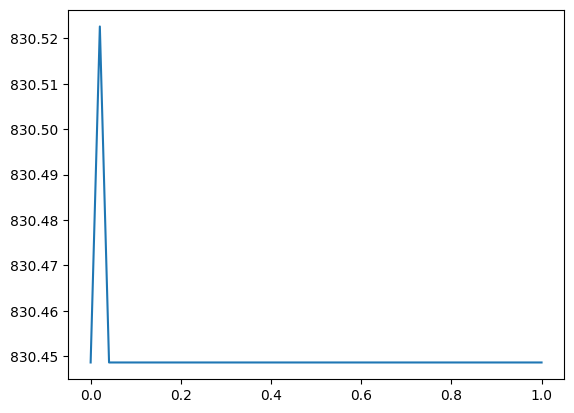

In [71]:
import matplotlib.pyplot as plt
plt.plot(scenarios, objs)

In [72]:
wind_sense = [result.output['P'] for result in results]

In [73]:
wind_sense[0]

{('HO', 'Grid', 0, 0): 0.00325,
 ('HO', 'Grid', 0, 1): 0.0032499999999999994,
 ('HO', 'Grid', 0, 2): 0.00325,
 ('HO', 'Grid', 0, 3): 0.00325,
 ('HO', 'Grid', 0, 4): 0.00325,
 ('HO', 'Grid', 0, 5): 0.003728947368421052,
 ('HO', 'Grid', 0, 6): 0.005678947368421052,
 ('HO', 'Grid', 0, 7): 0.007628947368421051,
 ('HO', 'Grid', 0, 8): 0.009578947368421051,
 ('HO', 'Grid', 0, 9): 0.011528947368421052,
 ('HO', 'Grid', 0, 10): 0.01347894736842105,
 ('HO', 'Grid', 0, 11): 0.01542894736842105,
 ('HO', 'Grid', 0, 12): 0.017378947368421053,
 ('HO', 'Grid', 0, 13): 0.019328947368421053,
 ('HO', 'Grid', 0, 14): 0.02127894736842105,
 ('HO', 'Grid', 0, 15): 0.02322894736842105,
 ('HO', 'Grid', 0, 16): 0.025178947368421047,
 ('HO', 'Grid', 0, 17): 0.013478947368421049,
 ('HO', 'Grid', 0, 18): 0.015428947368421052,
 ('HO', 'Grid', 0, 19): 0.01737894736842105,
 ('HO', 'Grid', 0, 20): 0.019328947368421053,
 ('HO', 'Grid', 0, 21): 0.02127894736842105,
 ('HO', 'Grid', 0, 22): 0.023228947368421054,
 ('HO', '

In [74]:
wind_sense[-1]

{('HO', 'Grid', 0, 0): 0.00325,
 ('HO', 'Grid', 0, 1): 0.00325,
 ('HO', 'Grid', 0, 2): 0.00325,
 ('HO', 'Grid', 0, 3): 0.00325,
 ('HO', 'Grid', 0, 4): 0.00325,
 ('HO', 'Grid', 0, 5): 0.003728947368421052,
 ('HO', 'Grid', 0, 6): 0.0056789473684210525,
 ('HO', 'Grid', 0, 7): 0.007628947368421053,
 ('HO', 'Grid', 0, 8): 0.009578947368421051,
 ('HO', 'Grid', 0, 9): 0.011528947368421052,
 ('HO', 'Grid', 0, 10): 0.013478947368421052,
 ('HO', 'Grid', 0, 11): 0.015428947368421052,
 ('HO', 'Grid', 0, 12): 0.017378947368421053,
 ('HO', 'Grid', 0, 13): 0.019328947368421053,
 ('HO', 'Grid', 0, 14): 0.02127894736842105,
 ('HO', 'Grid', 0, 15): 0.02322894736842105,
 ('HO', 'Grid', 0, 16): 0.025178947368421047,
 ('HO', 'Grid', 0, 17): 0.013478947368421054,
 ('HO', 'Grid', 0, 18): 0.015428947368421052,
 ('HO', 'Grid', 0, 19): 0.017378947368421053,
 ('HO', 'Grid', 0, 20): 0.019328947368421053,
 ('HO', 'Grid', 0, 21): 0.02127894736842105,
 ('HO', 'Grid', 0, 22): 0.02322894736842105,
 ('HO', 'Grid', 0, 2